In [ ]:
"""
Wallet Model Training – **Support Vector Machine**
================================================

Companion notebook to *Wallet Model Training & SHAP Explainability*, using
an **SVM** classifier instead of Random Forest.

Complete pipeline:

1. Load the preprocessed dataset.
2. Preprocessing numerico/categorico identico all’altro notebook.
3. `SVC(probability=True)` model with hyperparameter search (C, kernel, gamma).
4. Evaluation with classification report and confusion matrix.
5. Global SHAP beeswarm plot (generic `Explainer`).
6. Local CIU explanations (optional).
7. Save pipeline and report.
"""


'\nWallet Model Training – **Support\xa0Vector\xa0Machine**\n================================================\n\nNotebook gemello di *Wallet Model Training & SHAP Explainability*, ma con un\nclassificatore **SVM** al posto della Random\xa0Forest.\n\nPipeline completa:\n\n1. Carica il dataset pre‑processato.\n2. Preprocessing numerico/categorico identico all’altro notebook.\n3. Modello `SVC(probability=True)` con ricerca iper‑parametri (C, kernel, gamma).\n4. Valutazione con report e confusion matrix.\n5. SHAP beeswarm globale (generic `Explainer`).\n6. CIU locale (opzionale).\n7. Salvataggio pipeline e report.\n'

In [28]:
# ----------------------------------------------------------------------
# Select the use case to process
# case_1.csv: CHAINABUSE fraud transactions with unknown transactions
# case_2.csv: ELLIPTIC++ fraud transactions with ELLIPTIC++ licit transactions
# case_3.csv: CHAINABUSE fraud transactions with ELLIPTIC++ licit transactions
# ----------------------------------------------------------------------

USE_CASE = "case_3.csv"

In [29]:
# ----------------------------------------------------------------------
# Configuration – edit paths or set env-vars before starting Jupyter
# ----------------------------------------------------------------------
from __future__ import annotations

import os
from pathlib import Path
import warnings

DATASET_PATH = Path(os.getenv(
    "DATASET_PATH",
    f"../../data/processed_data/{USE_CASE}",
    
))
MODEL_DIR = Path(os.getenv("MODEL_DIR", DATASET_PATH.parent / "models"))
MODEL_DIR.mkdir(parents=True, exist_ok=True)

REPORT_FILE = MODEL_DIR / "classification_report.txt"
MODEL_FILE  = MODEL_DIR / "rf_pipeline.joblib"

print(f"📄 Dataset: {DATASET_PATH}\n📂 Model dir: {MODEL_DIR}\n")

📄 Dataset: ../../data/processed_data/case_3.csv
📂 Model dir: ../../data/processed_data/models



In [30]:
# ----------------------------------------------------------------------
# Imports – ML & explainability stack
# ----------------------------------------------------------------------
import logging
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import shap           # generic Explainer
import ciu
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)
logging.basicConfig(level=logging.INFO, format="%(asctime)s – %(levelname)s – %(message)s")
logger = logging.getLogger(__name__)

In [31]:
# ----------------------------------------------------------------------
# Load dataset
# ----------------------------------------------------------------------
logger.info("Loading dataset…")
df = pd.read_csv(DATASET_PATH)
logger.info(f"Dataset shape: {df.shape}")

X = df.drop(columns="class")
y = df["class"]

2025-06-03 17:10:42,418 – INFO – Loading dataset…
2025-06-03 17:10:42,449 – INFO – Dataset shape: (13495, 22)


In [32]:
# ----------------------------------------------------------------------
# Identify numeric & categorical columns
# ----------------------------------------------------------------------
numeric_features     = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
logger.info(f"Numeric      : {len(numeric_features)}")
logger.info(f"Categorical : {len(categorical_features)}")


2025-06-03 17:10:42,456 – INFO – Numeric      : 21
2025-06-03 17:10:42,456 – INFO – Categorical : 0


In [33]:
# ----------------------------------------------------------------------
# Preprocessing pipelines
# ----------------------------------------------------------------------
numeric_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

oh_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    oh_kwargs["sparse_output"] = False
else:
    oh_kwargs["sparse"] = False

categorical_tf = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(**oh_kwargs)),
])

preprocessor = ColumnTransformer([
    ("num", numeric_tf, numeric_features),
    ("cat", categorical_tf, categorical_features),
])

In [34]:
# ----------------------------------------------------------------------
# Model & pipeline
# ----------------------------------------------------------------------
svm = SVC(probability=True, class_weight="balanced", random_state=42)
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", svm),
])

param_grid = {
    "classifier__kernel": ["linear", "rbf"],
    "classifier__C"     : [0.1, 1, 10],
    "classifier__gamma" : ["scale", "auto"],  # only affects RBF kernel
}

In [35]:
# ----------------------------------------------------------------------
# Train/test split & GridSearch
# ----------------------------------------------------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)

logger.info("Splitting train/test…")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

logger.info("GridSearchCV (SVM) running…")
gs = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)
logger.info(f"Best params: {gs.best_params_}")

best_model = gs.best_estimator_

2025-06-03 17:10:42,468 – INFO – Splitting train/test…
2025-06-03 17:10:42,471 – INFO – GridSearchCV (SVM) in corso…


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear; total time=   4.5s
[CV] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear; total time=   4.6s
[CV] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=linear; total time=   4.7s
[CV] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear; total time=   4.7s
[CV] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=linear; total time=   4.8s
[CV] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=linear; total time=   4.8s
[CV] END classifier__C=0.1, classifier__gamma=scale, classifier__kernel=linear; total time=   4.8s
[CV] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=linear; total time=   4.8s
[CV] END classifier__C=0.1, classifier__gamma=auto, classifier__kernel=linear; total time=   4.9s
[CV] END classifier__C=0.1, classifier__gamma=scale, 

2025-06-03 17:11:22,070 – INFO – Best params: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}


2025-06-03 17:11:22,420 – INFO – Classification report saved → ../../data/processed_data/models/classification_report.txt


              precision    recall  f1-score   support

       fraud       0.83      0.80      0.81      1269
       licit       0.83      0.85      0.84      1430

    accuracy                           0.83      2699
   macro avg       0.83      0.83      0.83      2699
weighted avg       0.83      0.83      0.83      2699



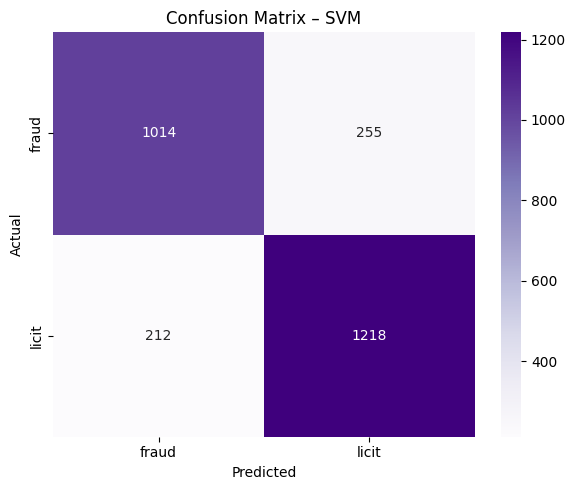

In [36]:
# ----------------------------------------------------------------------
# Evaluation
# ----------------------------------------------------------------------
y_pred  = best_model.predict(X_test)
report  = classification_report(y_test, y_pred, target_names=le.classes_)
cm      = confusion_matrix(y_test, y_pred)

print(report)
REPORT_FILE.write_text(report)
logger.info(f"Classification report saved → {REPORT_FILE}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [37]:
# ----------------------------------------------------------------------
# Persist pipeline
# ----------------------------------------------------------------------
joblib.dump(best_model, MODEL_FILE)
logger.info(f"SVM pipeline saved → {MODEL_FILE}")

2025-06-03 17:11:22,500 – INFO – SVM pipeline saved → ../../data/processed_data/models/rf_pipeline.joblib
